# Capstone 2 - Modeling

Question: What is the evolution of the impact of catastrophic events on the commercial aerial traffic in Canada, between 2001 and 2018?

Previous steps:
- In the Data Wrangling step, data was collected from two open source datasets, which were called "disaster" and "airline". Missing values have been managed, time values have been formatted, relevant columns have been preserved while the others have been dropped and both datasets were set to correspond to the same timeframe. The airline dataset has further been fragmented into two, corresponding to airline_total (at the country scale) and airline_local (at the province and territory scale). Here are the remaining cleaned dataset:
    - The disaster dataset contains the information relative to the natural disasters recorded in Canada during the period between 2001 and 2018.
    - The airline_total dataset contains the monthly total aerial movements for Canada for the period between 2001 and 2018.
    - The airline_local dataset contains the monthly aerial movements recorded for each airports of Canada for the period between 2001 and 2018
- In the Exploratory Data Analysis step, specific occurences of each type of disaster events were observed (absolute and yearly, and geographically). In the airline_total dataset, the frequence of total aerial movement by year and by month was verified, while in the airline_local dataset, the frequence of total aerial movement yearly and monthly was observed for each provinces and territories. Datasets were than merged to create disaster_local_monthly (merged_df).
- In the Pre-processing and Training Data Development step, dummy variables were assigned to categorical values ('EVENT_TYPE' and 'prov_ter'). The merged dataframe was further splitted into train and test data (75:25).

Associated notebooks:
- Data Wrangling: https://github.com/LaurenceFB/Capstone2/blob/main/Capstone2_DataWrangling_LForgetBrisson.ipynb
- Exploratory Data Analysis: https://github.com/LaurenceFB/Capstone2/blob/main/Capstone2_EDA_LForgetBrisson.ipynb
- Pre-processing and Training Data Development: https://github.com/LaurenceFB/Capstone2/blob/main/Capstone2_Pre-processingTraining_LForgetBrisson.ipynb


Modeling is used in this project to predict the aerial traffic (a continuous variable) through time considering the occurance of environmental disaster events. 

2 modeling methods will be tested on this dataset:
1) Linear regression; and 2) Random Forest.

- A linear regression model allows to simulates the relation between one or multiple independent variables and the target (dependent) variable, in order to assess trends and generate estimation or prevision.

- Random forest perfoms multiple decision trees, each making a prediction (classification or regression), in order to improve accuracy and minimize over-fitting.

In [1]:
# Importing pertinent packages
import numpy as np
import pandas as pd

from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

import math
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

import warnings

In [2]:
# Importing the dataset
df = pd.read_csv('df.csv')
df

,VALUE,year,month,Avalanche,Drought,Earthquake,Flood,Heat Event,Hurricane / Typhoon / Tropical Storm,Landslide,...,BC,MB,NB,NFL,NS,NWT,ON,QC,SK,YU
0,49568.0,2001.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,89058.0,2001.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0
2,19869.0,2001.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,0,0
3,4966.0,2001.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,0
4,7964.0,2001.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2360,3390.0,2018.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0
2361,92554.0,2018.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0
2362,40929.0,2018.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0
2363,11215.0,2018.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0


In [3]:
# Verification of the columns contained in the dataset.
df.columns

Index(['VALUE', 'year', 'month', 'Avalanche', 'Drought', 'Earthquake', 'Flood',
       'Heat Event', 'Hurricane / Typhoon / Tropical Storm', 'Landslide',
       'Storm - Unspecified / Other', 'Storm Surge',
       'Storms and Severe Thunderstorms', 'Tornado', 'Wildfire',
       'Winter Storm', 'sum_events', 'AB', 'BC', 'MB', 'NB', 'NFL', 'NS',
       'NWT', 'ON', 'QC', 'SK', 'YU'],
      dtype='object')

In [4]:
# Fonction initialization to evaluate the basic and tuned models.
# From willkoehrsen.github.io/_posts/2018-01-09-hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn.md
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

## 1) Linear regression

### 1.1 Linear model

In [5]:
# Spliting data into training and testing set
X = df.drop('VALUE', axis = 1)
y = df.VALUE

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [6]:
# Initialization of the model and fit.
rModel = linear_model.LinearRegression(normalize=True)
rModel.fit(X_train, y_train)

LinearRegression(normalize=True)

In [7]:
# Model prediction.
y_pred = rModel.predict(X_test)

In [8]:
# Evaluation of the model.
print('R2 score:', metrics.r2_score(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

R2 score: 0.9531131547469025
RMSE: 8369.75709446194


In [9]:
# Evaluation of the model performances.
accuracy = evaluate(rModel, X_test, y_test)

Model Performance
Average Error: 4847.0507 degrees.
Accuracy = 77.68%.


Text(0, 0.5, 'Predicted values')

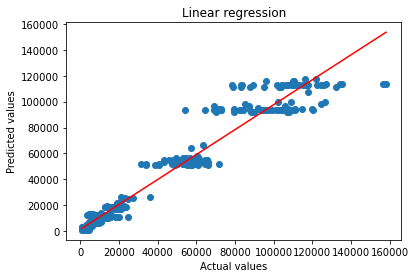

In [10]:
# Scatter plot of the predictions vs the actual result.
plt.scatter(y_test,y_pred)
plt.plot(np.unique(y_test), np.poly1d(np.polyfit(y_test, y_pred, 1))(np.unique(y_test)), color='r')
plt.title("Linear regression")
plt.xlabel("Actual values")
plt.ylabel("Predicted values")

### 1.2 Ordinary Least Squares (OLS) linear regression.

In [11]:
# Spliting data into training and testing set
X = sm.add_constant(X)
y = df.VALUE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Initialization and fit of the model.
rModel2 = sm.OLS(y_train, X_train).fit()

# Model prediction.
y_pred = rModel2.predict(X_test)

C:\Users\laurence\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [12]:
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

RMSE: 8378.779123595814


In [13]:
# Model summary.
rModel2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  VALUE   R-squared:                       0.946
Model:                            OLS   Adj. R-squared:                  0.946
Method:                 Least Squares   F-statistic:                     1368.
Date:                Sun, 30 Oct 2022   Prob (F-statistic):               0.00
Time:                        02:15:18   Log-Likelihood:                -19874.
No. Observations:                1892   AIC:                         3.980e+04
Df Residuals:                    1867   BIC:                         3.994e+04
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
year                                   -88.4168     39.544     -2.236      0.025    -165.972     -10.861
month                                 1.943e+05   7.28e+04      2.668      0.008    5.15e+04    3.37e+05
Avalanche                            -1.621e+04   5988.063     -2.708      0.007    -2.8e+04   -4470.770
Drought                               2360.6544   3934.893      0.600      0.549   -5356.596    1.01e+04
Earthquake                            3337.3955   8355.035      0.399      0.690    -1.3e+04    1.97e+04
Flood                                 4058.0025   1669.505      2.431      0.015     783.710    7332.295
Heat Event                            1.208e+04   8361.611      1.444      0.149   -4323.358    2.85e+04
Hurricane / Typhoon / Tropical Storm  1987.9349   4956.798      0.401      0.688   -7733.513    1.17e+04
Landslide                            -7497.5386   5039.293     -1.488      0.137   -1.74e+04    2385.701
Storm - Unspecified / Other            661.0678   2837.118      0.233      0.816   -4903.189    6225.325
Storm Surge                          -8620.3153   8357.393     -1.031      0.302    -2.5e+04    7770.500
Storms and Severe Thunderstorms       3062.6660   1687.123      1.815      0.070    -246.179    6371.511
Tornado                               5819.3511   2680.577      2.171      0.030     562.108    1.11e+04
Wildfire                              8780.2219   1719.803      5.105      0.000    5407.284    1.22e+04
Winter Storm                          -1.08e+04   2674.570     -4.039      0.000    -1.6e+04   -5556.052
sum_events                            -991.1141   1379.188     -0.719      0.472   -3696.026    1713.798
AB                                    3.877e+04   6652.155      5.829      0.000    2.57e+04    5.18e+04
BC                                    7.661e+04   6665.184     11.495      0.000    6.35e+04    8.97e+04
MB                                    2361.8897   6660.690      0.355      0.723   -1.07e+04    1.54e+04
NB                                   -4599.6323   6656.856     -0.691      0.490   -1.77e+04    8456.030
NFL                                  -9524.8530   6656.552     -1.431      0.153   -2.26e+04    3530.213
NS                                   -9419.8309   6661.300     -1.414      0.157   -2.25e+04    3644.546
NWT                                  -1.202e+04   6647.573     -1.808      0.071   -2.51e+04    1019.988
ON                                    9.627e+04   6641.164     14.496      0.000    8.32e+04    1.09e+05
QC                                    3.513e+04   6639.729      5.291      0.000    2.21e+04    4.82e+04
SK                                   -4921.5277   6654.936     -0.740      0.460    -1.8e+04    8130.368
YU                                   -

In [14]:
# Evaluation of the model.
accuracy = evaluate(rModel2, X_test, y_test)

Model Performance
Average Error: 4810.2830 degrees.
Accuracy = 77.72%.


Text(0, 0.5, 'Predicted values')

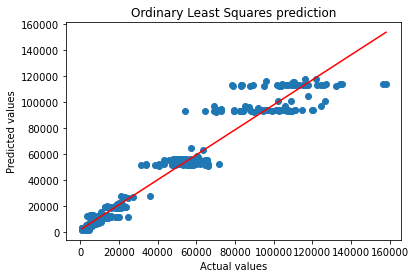

In [15]:
# Scatter plot of the predictions vs the actual result.
plt.scatter(y_test, y_pred)
plt.plot(np.unique(y_test), np.poly1d(np.polyfit(y_test, y_pred, 1))(np.unique(y_test)), color='r')
plt.title("Ordinary Least Squares prediction")
plt.xlabel("Actual values")
plt.ylabel("Predicted values")

## 2) Random forest regressor

In [16]:
# Spliting data into training and testing set.
X = df.drop('VALUE', axis = 1)
y = df.VALUE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Model initialization, fit and predict.
RFmodel = RandomForestRegressor(random_state=42)

RFmodel.fit(X_train, y_train)

y_pred = RFmodel.predict(X_test)

#### Default Parameters:
- 'bootstrap': True, # Method of selecting samples for training each tree
- 'criterion': 'mse',
- 'max_depth': None, # Maximum number of levels in tree
- 'max_features': 'auto', # Number of features to consider at every split
- 'max_leaf_nodes': None,
- 'min_impurity_decrease': 0.0,
- 'min_impurity_split': None,
- 'min_samples_leaf': 1, # Minimum number of samples required at each leaf node
- 'min_samples_split': 2, # Minimum number of samples required to split a node
- 'min_weight_fraction_leaf': 0.0,
- 'n_estimators': 10, # Number of trees in random forest
- 'n_jobs': 1,
- 'oob_score': False,
- 'random_state': 42,
- 'verbose': 0,
- 'warm_start': False

27


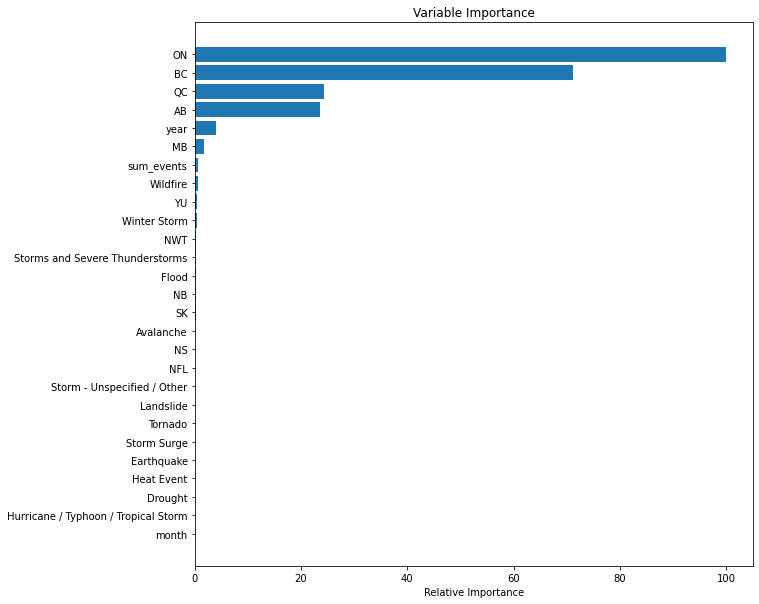

In [17]:
feature_importance = RFmodel.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

Text(0, 0.5, 'Predicted values')

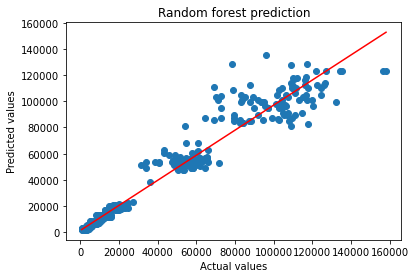

In [18]:
# Scatter plot of the predictions vs the actual result.
plt.scatter(y_test, y_pred)
plt.plot(np.unique(y_test), np.poly1d(np.polyfit(y_test, y_pred, 1))(np.unique(y_test)), color='r')
plt.title("Random forest prediction")
plt.xlabel("Actual values")
plt.ylabel("Predicted values")

In [19]:
print('R2 score:', metrics.r2_score(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

R2 score: 0.9520453385498967
RMSE: 8464.528323698649


In [20]:
# Evaluation of the model.
base_accuracy = evaluate(RFmodel, X_test, y_test)

Model Performance
Average Error: 4499.2455 degrees.
Accuracy = 82.91%.


## Random forest parameter tuning

### Cross validation

In [21]:
# K-Fold CV
# Preparation of the random grid to search for the best parameters.
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [22]:
# Initiating the random search model with 3 fold cross validation and fit.
search = RandomizedSearchCV(estimator = RFmodel,
                            param_distributions = random_grid,
                            n_iter = 100,
                            cv = 3,
                            verbose=2,
                            random_state=42,
                            n_jobs = -1)
search.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [23]:
# Printing the best parameters.
search.best_params_

{'n_estimators': 600,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 100,
 'bootstrap': True}

In [24]:
# Evaluation of the random tuned model.
random_accuracy = evaluate(search, X_test, y_test)

Model Performance
Average Error: 4428.8057 degrees.
Accuracy = 82.98%.


In [25]:
print('R2 score:', metrics.r2_score(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

R2 score: 0.9520453385498967
RMSE: 8464.528323698649


Text(0, 0.5, 'Predicted values')

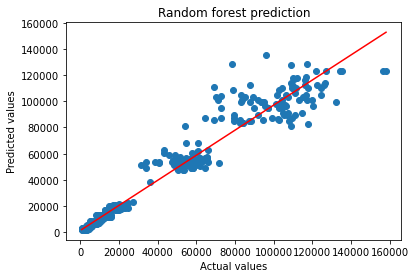

In [26]:
# Scatter plot of the predictions vs the actual result.
plt.scatter(y_test, y_pred)
plt.plot(np.unique(y_test), np.poly1d(np.polyfit(y_test, y_pred, 1))(np.unique(y_test)), color='r')
plt.title("Random forest prediction")
plt.xlabel("Actual values")
plt.ylabel("Predicted values")

Between the different tested model (standard linear regression, OSL linear regression, default random forest and tuned random forest), tuned random forest do the best prediction.